# Cloud Adjustment Maps

Make maps of cloud adjustments, also separate out ocean/land components. Makes Figures 5 - 7 of main text, Supplemental Figures S6 and S7.

Updated on February 5th to fix bugs identified by Mark Zelinka

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap
import xarray as xr
import scipy.interpolate as si
import scipy.stats as ss

/home/nick/anaconda2/lib/python2.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/nick/anaconda2/lib/python2.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
CMIP5_models = ["CanESM2", "CCSM4", "HadGEM2-A", "IPSL-CM5A-LR",  "MIROC5","MRI-CGCM3"]
CMIP6_models = ["CanESM5", "CESM2", "CNRM-CM6-1", "CNRM-ESM2-1", "GFDL-CM4", "HadGEM3-GC31-LL", 
                "IPSL-CM6A-LR", "MIROC6", "MRI-ESM2-0", "UKESM1-0-LL"]

#Load cloud adjustment maps (calculated separately)
data = np.load("CMIP5_net_adj.npy")
cmip5_ca = np.sum(data[:], axis = 1)


data = np.load("CMIP6_net_adj.npy")
cmip6_ca = np.sum(data[:], axis = 1)

#kernel lat/lon grid
lats = np.linspace( -90., 90., 64 )
lons = np.linspace( 0., 360., 128)

rad_lats = lats * np.pi / 180.
rad_lons = lons * np.pi / 180.
cos_lat = np.expand_dims(np.expand_dims(np.cos(rad_lats), 0), 2)

#Global-mean cloud adjustments in CMIP5 (global-means of cloud adjustment maps)
gm_cmip5_ca = np.trapz(np.trapz(cmip5_ca * cos_lat, rad_lons, axis = 2), rad_lats, axis = 1) / 4. / np.pi
#Global-mean cloud adjustments in CMIP6 from Smith et al
gm_cmip6_ca = np.trapz(np.trapz(cmip6_ca * cos_lat, rad_lons, axis = 2), rad_lats, axis = 1) / 4. / np.pi

#convert from 4x to 2x
gm_cmip5_ca /= 2.
gm_cmip6_ca /= 2.

Now plot all models for each generation

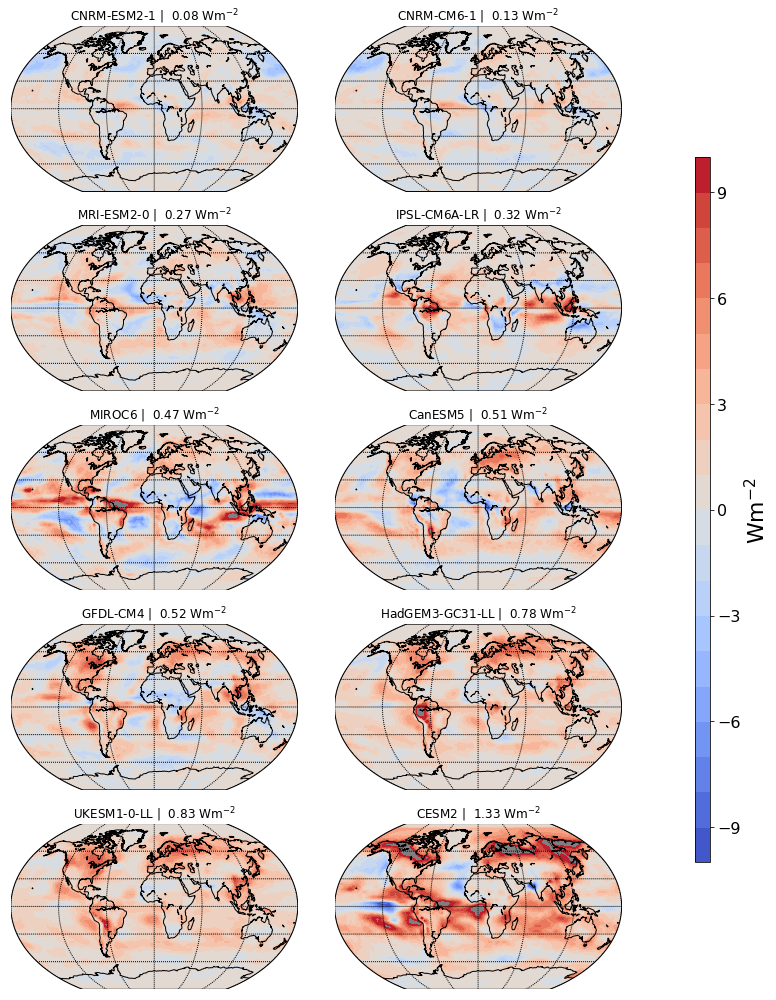

In [3]:
#CMIP6
fig = plt.figure( figsize = (12, 14) )
fig.subplots_adjust(right = 0.96, top = 0.94, left = 0.1, bottom = 0.12, hspace = 0.4, wspace = 0.3)

order = [ 6, 10, 2, 1, 7, 8, 4, 5, 3, 9] #order by global-mean cloud adjustment
m = len(order)

for i in range( m ):
   
    v = np.arange(-10., 11, 1.)
    ax = plt.subplot(5, 2, order[i])
    plt.title(CMIP6_models[i] + " |  %0.2f Wm$^{-2}$" % gm_cmip6_ca[i] )
    
    mlons, mlats = np.meshgrid(lons,lats)
    ma = Basemap(projection='kav7', lon_0 = 0, lat_1 = -60., lat_2 = 60.) 		   
    ma.drawcoastlines(linewidth=1.)
    ma.drawparallels(np.arange(-60., 90.,30.))
    ma.drawmeridians(np.arange(-180.,180.,60.))

    test = np.ma.masked_where(cmip6_ca[i] > 10., cmip6_ca[i])
    mask = np.ma.getmask(test)
    if np.max(mask) > 0.1:
        levs = np.arange(0., 99., 9.)
        ma.contourf( mlons, mlats, mask, levs, colors = 'k', alpha = 0.5, latlon = True)
    cset = ma.contourf( mlons, mlats, cmip6_ca[i], v, cmap = plt.cm.coolwarm, latlon = True)

fig.tight_layout()
fig.subplots_adjust(right = 0.85)

cbar_ax = fig.add_axes([0.87, 0.14, 0.017, 0.7])
cb = fig.colorbar(cset, cax=cbar_ax)
cb.set_label( "Wm$^{-2}$", fontsize = 22  )
cb.ax.tick_params(labelsize=16)

plt.savefig("CMIP6_cloud_adj_maps.png")
plt.savefig("CMIP6_cloud_adj_maps.pdf")

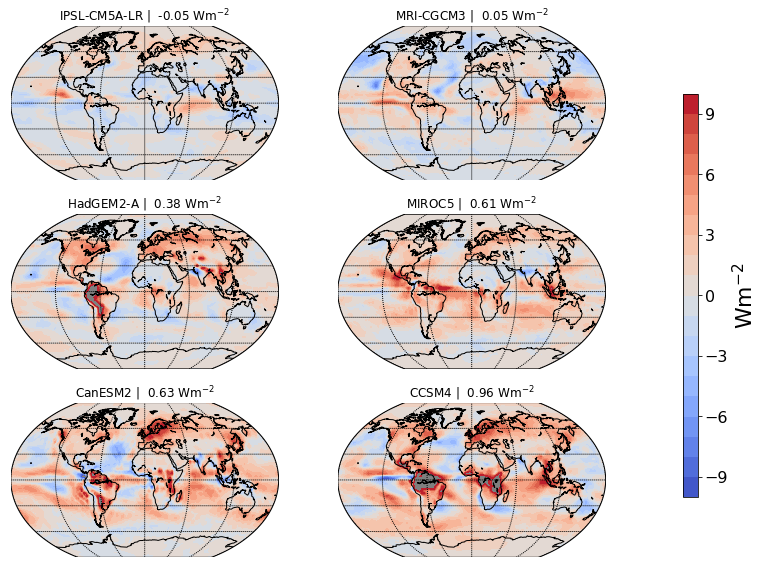

In [4]:
#CMIP5
fig = plt.figure( figsize = (12, 8) )
fig.subplots_adjust(right = 0.96, top = 0.94, left = 0.1, bottom = 0.12, hspace = 0.4, wspace = 0.3)

order = [2, 4, 1, 5, 3, 6] #order by global-mean cloud adjustment
order = [5, 6, 3, 1, 4, 2] #order by global-mean cloud adjustment

m = len(order)

for i in range( m ):
   
    v = np.arange(-10., 11, 1.)
    ax = plt.subplot(3, 2, order[i])
    plt.title(CMIP5_models[i] + " |  %0.2f Wm$^{-2}$" % gm_cmip5_ca[i] )
    
    mlons, mlats = np.meshgrid(lons,lats)
    ma = Basemap(projection='kav7', lon_0 = 0, lat_1 = -60., lat_2 = 60.) 		   
    ma.drawcoastlines(linewidth=1.)
    ma.drawparallels(np.arange(-60., 90.,30.))
    ma.drawmeridians(np.arange(-180.,180.,60.))

    test = np.ma.masked_where(cmip5_ca[i] > 10., cmip5_ca[i])
    mask = np.ma.getmask(test)
    if np.max(mask) > 0.1:
        levs = np.arange(0., 99., 9.)
        ma.contourf( mlons, mlats, mask, levs, colors = 'k', alpha = 0.5, latlon = True)
    cset = ma.contourf( mlons, mlats, cmip5_ca[i], v, cmap = plt.cm.coolwarm, latlon = True)


fig.tight_layout()
fig.subplots_adjust(right = 0.86)

cbar_ax = fig.add_axes([0.87, 0.13, 0.017, 0.7])
cb = fig.colorbar(cset, cax=cbar_ax)
cb.set_label( "Wm$^{-2}$", fontsize = 22  )
cb.ax.tick_params(labelsize=16)

plt.savefig("CMIP5_cloud_adj_maps.png")
plt.savefig("CMIP5_cloud_adj_maps.pdf")
plt.show()

## Land versus ocean

In [5]:
#First load \lambda_{SW, CL} -- read these off table
CMIP5_sw = [-0.29, -0.09, 0.29, 0.61, -0.38, 0.25]
CMIP5_lw = [0.74, 0.26, 0.36, 0.51, 0.26, -0.03]

#\lambda_{SW, CL}
CMIP6_sw = [-0.02, 0.79, -0.02, 0.03, 0.03, 0.98, 0.14, -0.13, 0.12, 0.93]
CMIP6_lw = [0.82, 0.17, 0.57, 0.53, 0.53, -0.19, 0.23, 0.26, 0.26, -0.12]

In [6]:
#generate land/ocean mask
#I only downloaded the land fraction for one model, so have to interpolate everything onto common grid
datapath_cmip = '/home/nick/Work/Projects/Feedback_Issues/CMIP_data/'#'/home/nick/data/CMIP5/HadGEM2-ES'
land_mask = xr.open_dataset(datapath_cmip+'sftlf_fx_HadGEM2-ES_abrupt4xCO2_r0i0p0.nc')

land_mask = land_mask.sftlf / 100.
d1, d2 = np.shape(land_mask)

nlats = land_mask["lat"][:]
nlons = land_mask["lon"][:]

f = si.interp2d( nlons, nlats, land_mask, kind = 'cubic')
nlm = f( lons, lats)

l1 = len(cmip5_ca[:, 0, 0]) #number of CMIP5 models
l2 = len(cmip6_ca[:, 0, 0]) #number of CMIP6 models

land_cmip5_ca = np.ma.zeros( ( (l1, 64, 128) ))
ocean_cmip5_ca = np.ma.zeros( ( (l1, 64, 128) ))

land_cmip6_ca = np.ma.zeros( ( (l2, 64, 128) ))
ocean_cmip6_ca = np.ma.zeros( ( (l2, 64, 128) ))

for i in range( l1 ):   
    land_cmip5_ca[i] = np.ma.masked_where( nlm < 0.1, cmip5_ca[i])
    ocean_cmip5_ca[i] = np.ma.masked_where( nlm > 0.1, cmip5_ca[i])
for i in range( l2 ):   
    land_cmip6_ca[i] = np.ma.masked_where( nlm < 0.1, cmip6_ca[i])
    ocean_cmip6_ca[i] = np.ma.masked_where( nlm > 0.1, cmip6_ca[i])
    
#Need land/ocean fraction
mask = np.ma.getmask(ocean_cmip6_ca[i] )
lf = float(np.sum(mask)) / 64. / 128.

cmip5_land = np.trapz(np.trapz(land_cmip5_ca * cos_lat, rad_lons, axis = 2), rad_lats, axis = 1) / 4. / np.pi / lf
cmip5_ocean = np.trapz(np.trapz(ocean_cmip5_ca * cos_lat, rad_lons, axis = 2), rad_lats, axis = 1) / 4. / np.pi / (1. - lf)

cmip6_land = np.trapz(np.trapz(land_cmip6_ca * cos_lat, rad_lons, axis = 2), rad_lats, axis = 1) / 4. / np.pi / lf
cmip6_ocean = np.trapz(np.trapz(ocean_cmip6_ca * cos_lat, rad_lons, axis = 2), rad_lats, axis = 1) / 4. / np.pi / (1. - lf)

#Divide by 2 to convert from 4x to 2x
cmip5_land = cmip5_land / 2.
cmip5_ocean = cmip5_ocean / 2.

cmip6_land = cmip6_land / 2. 
cmip6_ocean = cmip6_ocean / 2.

In [7]:
#Take differences
dif_land_adj = [cmip6_land[8] - cmip5_land[0], cmip6_land[7] - cmip5_land[1], cmip6_land[6] - cmip5_land[2], cmip6_land[0] - cmip5_land[3], cmip6_land[5] - cmip5_land[4], cmip6_land[1] - cmip5_land[5]]
dif_ocean_adj = [cmip6_ocean[8] - cmip5_ocean[0], cmip6_ocean[7] - cmip5_ocean[1], cmip6_ocean[6] - cmip5_ocean[2], cmip6_ocean[0] - cmip5_ocean[3], cmip6_ocean[5] - cmip5_ocean[4], cmip6_ocean[1] - cmip5_ocean[5]]

In [8]:
#feedbacks and cloud adjustments, taken from txt files:
lambda_SW = [0.12, -0.13, 0.14, -0.02, 0.03, 0.98, 0.79]
cl_adj = [0.29, 0.35, 0.47, 0.22, 0.56, 0.74, 1.07]

#aquaplanet cloud adjustments
aqua_cl_adj = [0.72, 0.47, 0.16, 0.2, 0.52, 0.58, 1.62] 

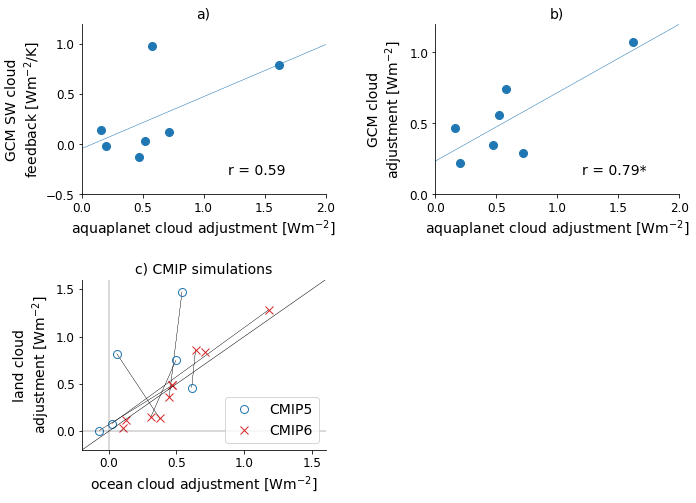

In [9]:
#Add some colors for plotting
cs = [(31 / 255., 119 / 255., 180 / 255.), (44. / 255., 160 / 255., 44 / 255.), (214 / 255., 39 / 255., 40 / 255.), (255 / 255., 127 / 255., 14 / 255.) ]
x = np.linspace(-10., 10., 100) #for plotting

fig = plt.figure( figsize = (10, 8) )
plt.subplots_adjust(left = 0.15, right = 0.98, bottom = 0.16, top = 0.9, wspace = 0.45, hspace = 0.5)

ax = plt.subplot(2, 2, 1)
plt.title("a)", fontsize = 14)

plt.plot( aqua_cl_adj, lambda_SW, 'o', markersize = 8)

slope, inter = ss.linregress( aqua_cl_adj, lambda_SW)[:2]
plt.plot(x, x * slope + inter, color = cs[0], linewidth = 0.5)

pval = ss.linregress(aqua_cl_adj, lambda_SW)[3]
if pval < 0.05:
    plt.text( 1.2, -0.3, 'r = %0.2f' % np.corrcoef(aqua_cl_adj, lambda_SW)[0, 1 ],  fontsize = 14, weight = 'bold' )
else:
    plt.text( 1.2, -0.3, 'r = %0.2f' % np.corrcoef(aqua_cl_adj, lambda_SW)[0, 1 ],  fontsize = 14 )


plt.xlabel("aquaplanet cloud adjustment [Wm$^{-2}$]", fontsize = 14 )
plt.ylabel("GCM SW cloud\nfeedback [Wm$^{-2}$/K]", fontsize = 14 )
plt.xlim([0., 2.])
plt.ylim([-0.5, 1.2])
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
plt.xticks([ 0., 0.5, 1., 1.5, 2.], fontsize = 12)
plt.yticks([-0.5, 0., 0.5, 1.], fontsize = 12)

ax = plt.subplot(2, 2, 2)
plt.title("b)", fontsize = 14)

plt.plot( aqua_cl_adj, cl_adj, 'o', markersize = 8)

slope, inter = ss.linregress( aqua_cl_adj, cl_adj)[:2]
plt.plot(x, x * slope + inter, color = cs[0], linewidth = 0.5)

plt.xlim([0., 2.])
plt.ylim([0., 1.2])
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
plt.xticks([0., 0.5, 1., 1.5, 2.], fontsize = 12)
plt.yticks([0., 0.5, 1.], fontsize = 12)

plt.xlabel("aquaplanet cloud adjustment [Wm$^{-2}$]", fontsize = 14 )
plt.ylabel("GCM cloud\nadjustment [Wm$^{-2}$]", fontsize = 14 )

pval = ss.linregress(aqua_cl_adj, cl_adj)[3]
if pval < 0.05:
    plt.text( 1.2, 0.14, 'r = %0.2f*' % np.corrcoef(aqua_cl_adj, cl_adj)[0, 1 ],  fontsize = 14 )
else:
    plt.text( 1.2, 0.15, 'r = %0.2f' % np.corrcoef(aqua_cl_adj, cl_adj)[0, 1 ],  fontsize = 14 )

ax = plt.subplot(2, 2, 3)
plt.title("c) CMIP simulations", fontsize = 14)

plt.plot(cmip5_ocean, cmip5_land, 'o', markersize = 8, markerfacecolor = 'None', markeredgecolor = cs[0])
plt.plot(cmip6_ocean, cmip6_land, 'x', markersize = 8, markerfacecolor = 'None', markeredgecolor = cs[2])
plt.arrow(cmip5_ocean[0], cmip5_land[0], dif_ocean_adj[0], dif_land_adj[0], shape = 'right', color = 'k', linewidth = 0.2)
plt.arrow(cmip5_ocean[1], cmip5_land[1], dif_ocean_adj[1], dif_land_adj[1], shape = 'right', color = 'k', linewidth = 0.2)
plt.arrow(cmip5_ocean[2], cmip5_land[2], dif_ocean_adj[2], dif_land_adj[2], shape = 'right', color = 'k', linewidth = 0.2)
plt.arrow(cmip5_ocean[3], cmip5_land[3], dif_ocean_adj[3], dif_land_adj[3], shape = 'right', color = 'k', linewidth = 0.2)
plt.arrow(cmip5_ocean[4], cmip5_land[4], dif_ocean_adj[4], dif_land_adj[4], shape = 'right', color = 'k', linewidth = 0.2)
plt.arrow(cmip5_ocean[5], cmip5_land[5], dif_ocean_adj[5], dif_land_adj[5], shape = 'right', color = 'k', linewidth = 0.2)


x = np.linspace(-2., 2., 10)
plt.plot(x, x, 'k', linewidth = 0.5)

ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
plt.xticks([0., 0.5, 1., 1.5], fontsize = 12)
plt.yticks([0., 0.5, 1., 1.5], fontsize = 12)

plt.legend(["CMIP5", "CMIP6"], loc = "lower right", fontsize = 14)

plt.xlabel("ocean cloud adjustment [Wm$^{-2}$]", fontsize = 14)
plt.ylabel("land cloud\nadjustment [Wm$^{-2}$]", fontsize = 14)

plt.xlim([-0.2, 1.6])
plt.ylim([-0.2, 1.6])

plt.axvline(x = 0, color = 'k', linewidth = 0.3)
plt.axhline(y = 0, color = 'k', linewidth = 0.3)

plt.savefig("aquaplanet_results.png")
plt.savefig("aquaplanet_results.pdf")

### Adjusted low cloud feedbacks

In [10]:
#Use the Scott et al adjustment

CMIP5_mod2 = ["CanESM2", "CCSM4", "HadGEM2-A", "IPSL-CM5A-LR",  "MIROC5","MRI-CGCM3"]
CMIP6_mod2 = ["CanESM5", "CESM2", "CNRM-CM6-1", "CNRM-ESM2-1", "GFDL-CM4", "HadGEM3-GC31-LL", "IPSL-CM6A-LR", "MIROC6", "MRI-ESM2-0", "UKESM1-0-LL"]

#Load cloud adjustment maps (calculated separately)
data = np.load("CMIP5_adjusted_low_cloud.npy")
cmip5_ca = data["u"][:]

data = np.load("CMIP6_adjusted_low_cloud.npy")
cmip6_ca = data["u"][:]

#Global-mean cloud adjustments in CMIP5 (global-means of cloud adjustment maps)
gm_cmip5_ca = np.trapz(np.trapz(cmip5_ca * cos_lat, rad_lons, axis = 2), rad_lats, axis = 1) / 4. / np.pi
#Global-mean cloud adjustments in CMIP6 from Smith et al
gm_cmip6_ca = np.trapz(np.trapz(cmip6_ca * cos_lat, rad_lons, axis = 2), rad_lats, axis = 1) / 4. / np.pi

#convert from 4x to 2x
gm_cmip5_ca /= 2.
gm_cmip6_ca /= 2.

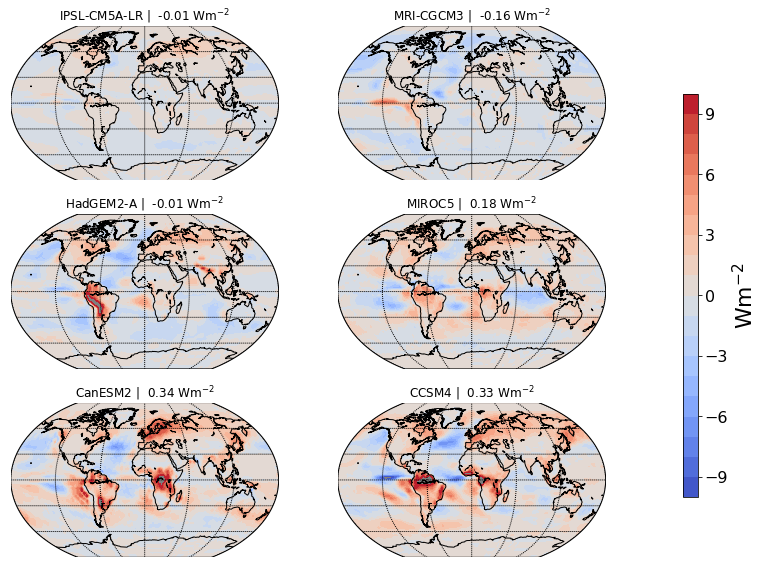

In [11]:
#CMIP5

fig = plt.figure( figsize = (12, 8) )
fig.subplots_adjust(right = 0.96, top = 0.94, left = 0.1, bottom = 0.12, hspace = 0.4, wspace = 0.3)

order = [5, 6, 3, 1, 4, 2] #order by global-mean cloud adjustment
m = len(order)

for i in range( m ):
   
    v = np.arange(-10., 11, 1.)
    ax = plt.subplot(3, 2, order[i])
    plt.title(CMIP5_mod2[i] + " |  %0.2f Wm$^{-2}$" % gm_cmip5_ca[i] )
    
    mlons, mlats = np.meshgrid(lons,lats)
    ma = Basemap(projection='kav7', lon_0 = 0, lat_1 = -60., lat_2 = 60.) 		   
    ma.drawcoastlines(linewidth=1.)
    ma.drawparallels(np.arange(-60., 90.,30.))
    ma.drawmeridians(np.arange(-180.,180.,60.))

    test = np.ma.masked_where(cmip5_ca[i] > 10., cmip5_ca[i])
    mask = np.ma.getmask(test)
    if np.max(mask) > 0.1:
        levs = np.arange(0., 99., 9.)
        ma.contourf( mlons, mlats, mask, levs, colors = 'k', alpha = 0.5, latlon = True)
    cset = ma.contourf( mlons, mlats, cmip5_ca[i], v, cmap = plt.cm.coolwarm, latlon = True)


fig.tight_layout()
fig.subplots_adjust(right = 0.86)

cbar_ax = fig.add_axes([0.87, 0.13, 0.017, 0.7])
cb = fig.colorbar(cset, cax=cbar_ax)
cb.set_label( "Wm$^{-2}$", fontsize = 22  )
cb.ax.tick_params(labelsize=16)

plt.savefig("CMIP5_low_cloud_adj_maps.png")
plt.savefig("CMIP5_low_cloud_adj_maps.pdf")
plt.show()

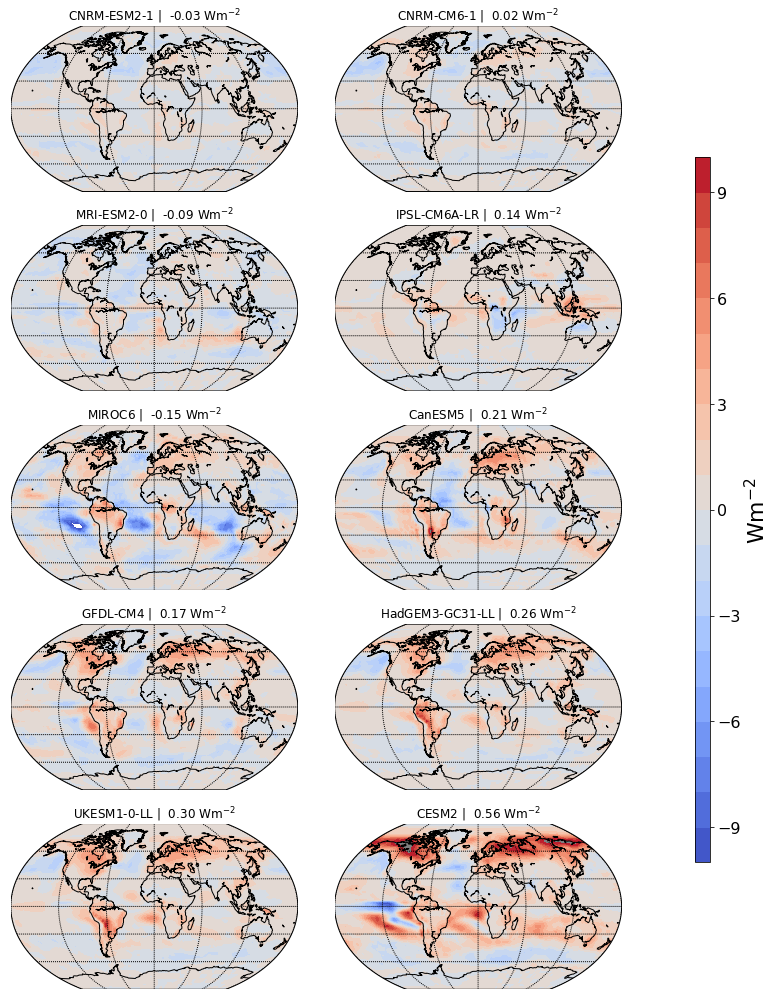

In [12]:
#CMIP6
fig = plt.figure( figsize = (12, 14) )
fig.subplots_adjust(right = 0.96, top = 0.94, left = 0.1, bottom = 0.12, hspace = 0.4, wspace = 0.3)

order = [ 6, 10, 2, 1, 7, 8, 4, 5, 3, 9] #order by global-mean cloud adjustment
m = len(order)

for i in range( m ):
   
    v = np.arange(-10., 11, 1.)
    ax = plt.subplot(5, 2, order[i])
    plt.title(CMIP6_mod2[i] + " |  %0.2f Wm$^{-2}$" % gm_cmip6_ca[i] )
    
    mlons, mlats = np.meshgrid(lons,lats)
    ma = Basemap(projection='kav7', lon_0 = 0, lat_1 = -60., lat_2 = 60.) 		   
    ma.drawcoastlines(linewidth=1.)
    ma.drawparallels(np.arange(-60., 90.,30.))
    ma.drawmeridians(np.arange(-180.,180.,60.))

    test = np.ma.masked_where(cmip6_ca[i] > 10., cmip6_ca[i])
    mask = np.ma.getmask(test)
    if np.max(mask) > 0.1:
        levs = np.arange(0., 99., 9.)
        ma.contourf( mlons, mlats, mask, levs, colors = 'k', alpha = 0.5, latlon = True)
    cset = ma.contourf( mlons, mlats, cmip6_ca[i], v, cmap = plt.cm.coolwarm, latlon = True)

fig.tight_layout()
fig.subplots_adjust(right = 0.85)

cbar_ax = fig.add_axes([0.87, 0.14, 0.017, 0.7])
cb = fig.colorbar(cset, cax=cbar_ax)
cb.set_label( "Wm$^{-2}$", fontsize = 22  )
cb.ax.tick_params(labelsize=16)

plt.savefig("CMIP6_low_cloud_adj_maps.png")
plt.savefig("CMIP6_low_cloud_adj_maps.pdf")